In [8]:
import pandas as pd
import matplotlib.pyplot as plt

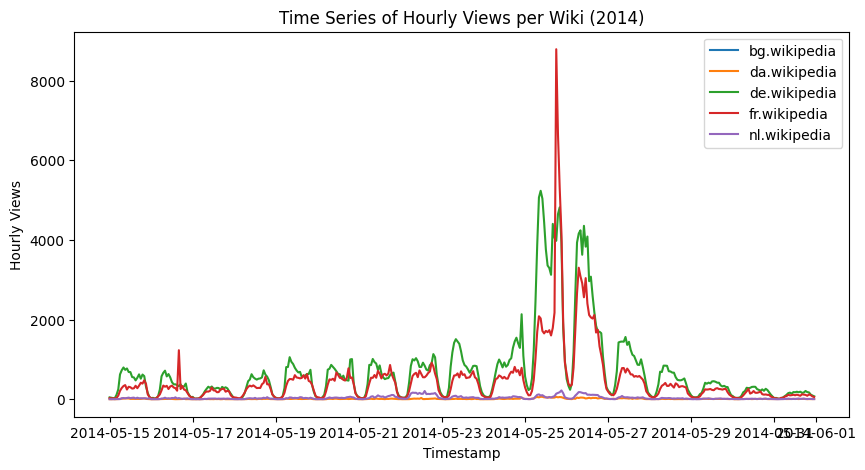

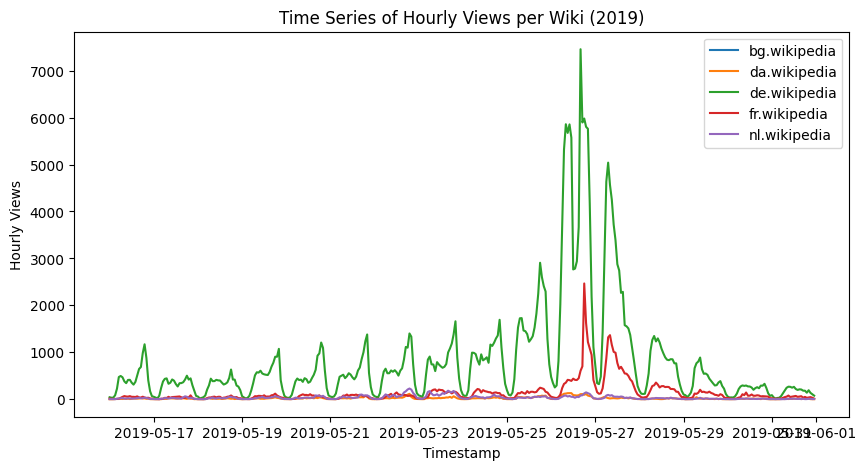

In [10]:
df = pd.read_csv("data/merged_election_pages.csv")

# Convert timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Filter data for 2014
df_2014 = df[df['timestamp'].dt.year == 2014]

# Filter data for 2019
df_2019 = df[df['timestamp'].dt.year == 2019]

# Plot for 2014
plt.figure(figsize=(10, 5))
groups_2014 = df_2014.groupby('wikicode')
for wikicode, group in groups_2014:
    plt.plot(group['timestamp'], group['hourly_views'], label=wikicode)

plt.xlabel('Timestamp')
plt.ylabel('Hourly Views')
plt.title('Time Series of Hourly Views per Wiki (2014)')
plt.legend()
plt.show()

# Plot for 2019
plt.figure(figsize=(10, 5))
groups_2019 = df_2019.groupby('wikicode')
for wikicode, group in groups_2019:
    plt.plot(group['timestamp'], group['hourly_views'], label=wikicode)

plt.xlabel('Timestamp')
plt.ylabel('Hourly Views')
plt.title('Time Series of Hourly Views per Wiki (2019)')
plt.legend()
plt.show()